In [80]:
%load_ext autoreload
import os
import numpy as np 
import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import project_pca, calculate_Q_metrics, classify_enterotypes

from warnings import simplefilter
simplefilter('ignore')

%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and preprocess data

In [81]:
# # load AGP-HMP data
# !wget https://figshare.com/ndownloader/files/33927092 -O ./data.zip
# !unzip ./data.zip 

In [82]:
# # Load data from Arumugam et al. 2011
# !wget http://www.bork.embl.de/Docu/Arumugam_et_al_2011/data/tables/MetaHIT_41SangerSamples.genus.txt -O ./data/MetaHIT_41SangerSamples_genus.txt
# !wget http://www.bork.embl.de/Docu/Arumugam_et_al_2011/data/tables/MetaHIT_85IlluminaSamples.genus.txt -O ./data/MetaHIT_85IlluminaSamples_genus.txt
# !wget http://www.bork.embl.de/Docu/Arumugam_et_al_2011/data/tables/Turnbaugh_154Pyroseq16S.genus.txt -O ./data/Turnbaugh_154Pyroseq16S_genus.txt
# !wget https://enterotype.embl.de/MetaHIT_SangerSamples.genus.txt -O ./data/MetaHIT_33SangerSamples_genus.txt

In [105]:
data_orig = {}
y_orig = {}

for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        dataframe = pd.read_csv(f'./data/{dataset_name}/pivot_{tax}_normalized.csv', sep=';')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1)


processed_root = 'data_processed'
pca_root = './results/pca'

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.44it/s]


In [106]:
# uncomment to use small datasets

data_orig = {}
df_Sanger = pd.read_table('./data/MetaHIT_33SangerSamples_genus.txt').T
df_Sanger.columns = df_Sanger.iloc[0]
df_Sanger.drop('Unnamed: 0', inplace=True)

df_Illumina = pd.read_table('./data/MetaHIT_85IlluminaSamples_genus.txt').T
df_Pyroseq = pd.read_table('./data/Turnbaugh_154Pyroseq16S_genus.txt').T

data_orig['Sanger_g'] = df_Sanger.astype(np.float64)
data_orig['Illumina_g'] = df_Illumina.astype(np.float64)
data_orig['Pyroseq_g'] = df_Pyroseq.astype(np.float64)

for k,v in data_orig.items():
    v.index = np.arange(v.shape[0])
    data_orig[k] = v

processed_root = 'data_processed_small'
pca_root = './results/pca'

In [107]:
# # uncomment to use synthetic data

# data_orig = {}
# for path in glob.glob('data/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1]
#     data_orig[label] = dataframe.drop('target', axis=1)

# processed_root = 'data_processed/synthetic'
# pca_root = './results/pca/synthetic'

# Preprocessing

In [108]:
def index_to_mask(index, N_orig):
    
    mask = np.zeros((N_orig))
    
    for i in index:
        mask[i] = 1
    return mask.astype(bool)

# requirement that OTU shound be present at least in RARITY_THRESHOLD percentage of population
RARITY_THRESHOLD = 0.01 
# requirement that OTU variance among population 
STD_THRESHOLD = 1e-3
PATHOLOGICAL_ABUNDANCE_THRESHOLD = None #0.7 

if PATHOLOGICAL_ABUNDANCE_THRESHOLD is not None:
    DATA_SPECIFICATION = f'_pat{PATHOLOGICAL_ABUNDANCE_THRESHOLD}'

else:
    DATA_SPECIFICATION = ''
    
processed_root = processed_root + DATA_SPECIFICATION
os.makedirs(processed_root, exist_ok=True)

preprocessed_data = {}
preprocessing_mask = {}
y_orig = {}
save_y_orig = False

for label, df in data_orig.items():
            
    df_proc = df.copy()
    df_proc.drop_duplicates(inplace=True)
    N = df_proc.shape[0]
    
    # too rare OTU
    rare_otu_mask = (df_proc > 0).sum(0) / N < RARITY_THRESHOLD
    
    # too low std
    std_otu_mask = df_proc.std(0) < STD_THRESHOLD
    
    mask = rare_otu_mask + std_otu_mask
    df_proc = df_proc.iloc[:,~mask.values]
    
    if PATHOLOGICAL_ABUNDANCE_THRESHOLD is not None:
        path_abundance_mask = df_proc.max(1) < PATHOLOGICAL_ABUNDANCE_THRESHOLD
        df_proc = df_proc[path_abundance_mask]
    
    preprocessed_data[label] = df_proc
    preprocessing_mask[label] = index_to_mask(df_proc.index, df.shape[0])
    
    path = os.path.join(processed_root, f'{label}.csv')
    df_proc.to_csv(path)
    
    n0 = df.shape[0] 
    n1 = df_proc.shape[0]
    
    print(f'{label} Data preserved: {n1/n0}')
    print(f'{label} Orig shape: {df.shape}, processed shape: {df_proc.shape}')
    
    dataset_name, tax = label.split('_')
    # calculate pre-defined enterotype labels 
    if tax == 'g' and dataset_name in ['AGP', 'HMP']:
        y_orig[dataset_name] = classify_enterotypes(df_proc)
        save_y_orig = True
        
        
np.save(os.path.join(processed_root, 'preprocessing_mask'), preprocessing_mask)
if save_y_orig:
    np.save(os.path.join(processed_root,'enterotypes_clf'), y_orig)

AGP_o Data preserved: 0.8319840185048891
AGP_o Orig shape: (9511, 168), processed shape: (7913, 39)
AGP_f Data preserved: 0.9686678582693723
AGP_f Orig shape: (9511, 258), processed shape: (9213, 69)
AGP_g Data preserved: 0.9670907370413205
AGP_g Orig shape: (9511, 535), processed shape: (9198, 108)
HMP_o Data preserved: 0.7170263788968825
HMP_o Orig shape: (4587, 179), processed shape: (3289, 39)
HMP_f Data preserved: 0.7976891214301286
HMP_f Orig shape: (4587, 267), processed shape: (3659, 70)
HMP_g Data preserved: 0.7721822541966427
HMP_g Orig shape: (4587, 574), processed shape: (3542, 97)


# PCA

In [109]:
SAVE=False
pca_root = pca_root + DATA_SPECIFICATION
os.makedirs(pca_root, exist_ok=True)

data_pca = {}
pca_models = {}

for label, df in preprocessed_data.items():
    
    data_projected, pca, pca_proj, mae = project_pca(df, whiten=False)
       
    d_pca = data_projected.shape[1]
    d = df.shape[1]
    
    Q_loc, Q_glob = calculate_Q_metrics(df.values, data_projected)
    print(f'For {label}, dim orig: {d}, dim PCA: {d_pca}, mae: {np.round(mae,3)}, Q_loc: {np.round(Q_loc,3)}, Q_glob: {np.round(Q_glob,3)}')
    
    data_pca[label] = data_projected
    pca_models[label] = pca
    
    if SAVE:
        path = os.path.join(pca_root, f'{label}')
        np.savetxt(path, data_projected, delimiter = ';')

For AGP_o, dim orig: 39, dim PCA: 18, mae: 0.051
For AGP_f, dim orig: 69, dim PCA: 34, mae: 0.04
For AGP_g, dim orig: 108, dim PCA: 49, mae: 0.05
For HMP_o, dim orig: 39, dim PCA: 19, mae: 0.037
For HMP_f, dim orig: 70, dim PCA: 39, mae: 0.037
For HMP_g, dim orig: 97, dim PCA: 44, mae: 0.056


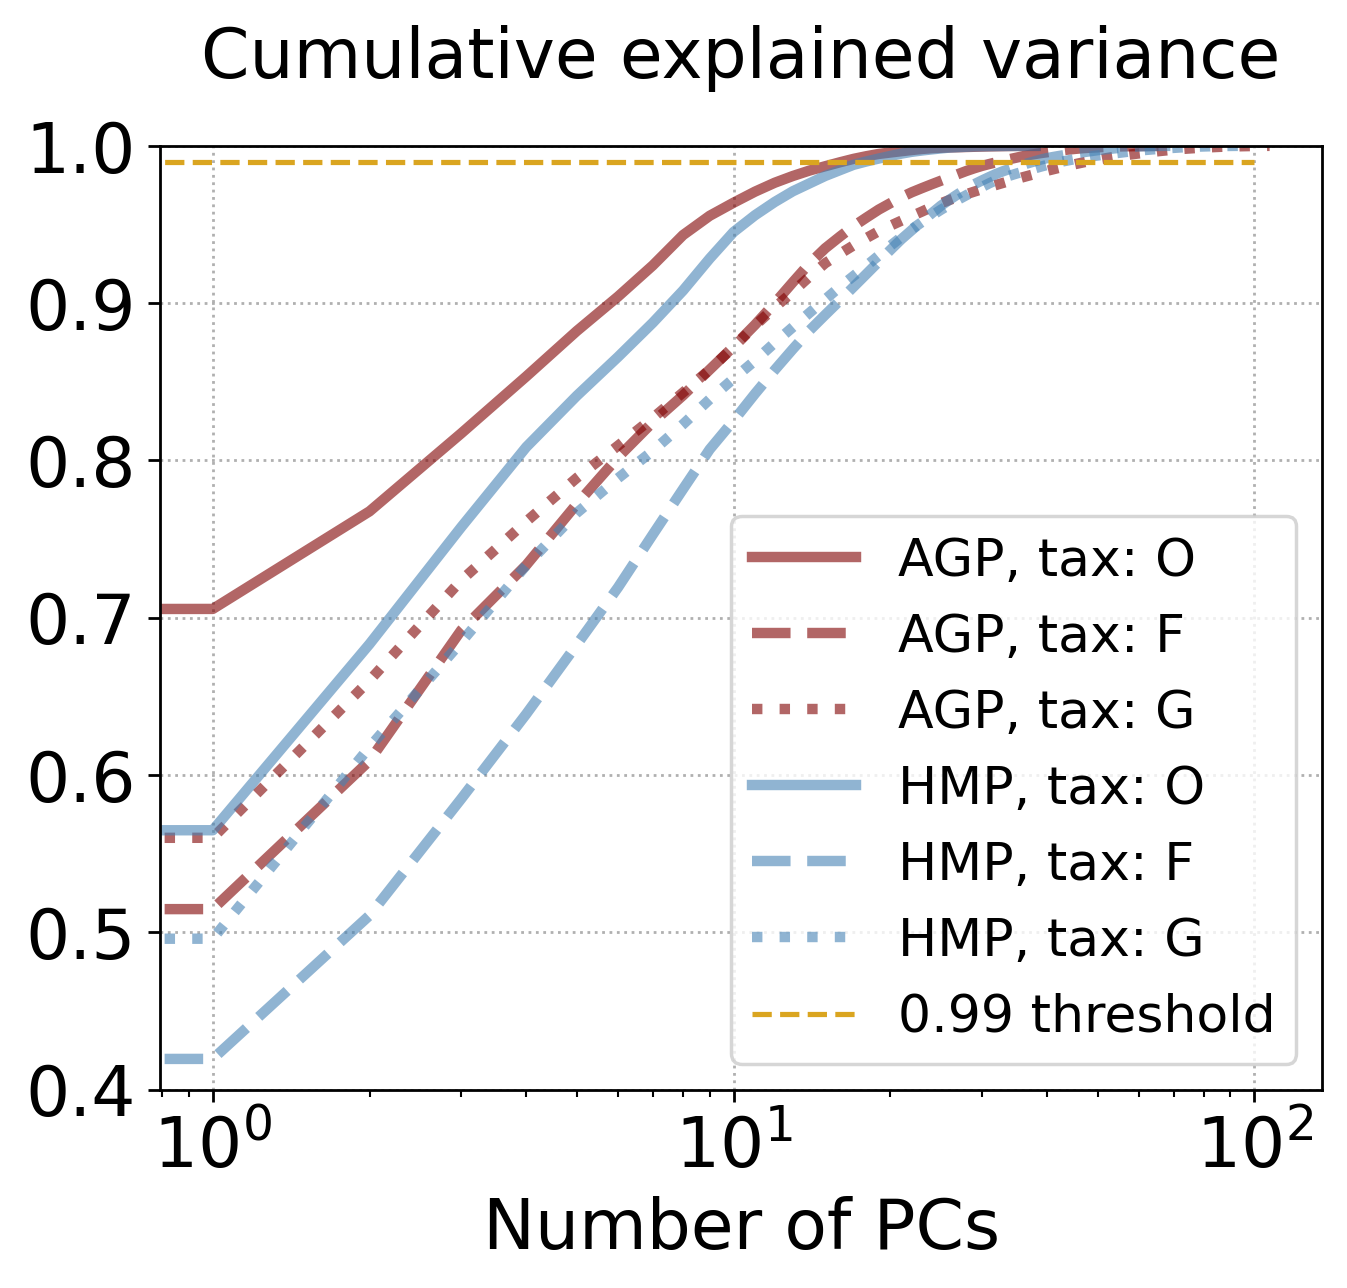

In [111]:
color_dict = {'AGP':'maroon', 'HMP':'steelblue'}
linestyle_dict = {'o':'solid', 'f':'dashed', 'g':'dotted'}

plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

plt.figure(figsize=(6,5), dpi=250)
plt.title(f"Cumulative explained variance", fontsize=20)
plt.xlabel("Number of PCs", fontsize=20)

plt.grid(linestyle="dotted")

cols = {}
scores = {}

for label,pca in pca_models.items():
    
    if not label.split('_')[0] in color_dict:
        continue
    
    ev = np.cumsum(pca.explained_variance_ratio_)
    
    dataset_name, tax_name = label.split('_')
    
    label_neat = dataset_name + f', tax: {tax_name.capitalize()}'
    
    plt.plot(ev, 
             linewidth=3, 
             label=label_neat,
             alpha=0.6,
             color=color_dict[dataset_name],
             linestyle=linestyle_dict[tax_name]
            )  
    
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_scores = np.linalg.norm(loadings, axis=1)
    
    cols[label] = [c.split('__')[1] for c in preprocessed_data[label].columns]
    scores[label] = loadings_scores
    
    try:
        aux_ind = cols[label].index('')
        cols[label].pop(aux_ind)
        scores[label] = np.delete(scores[label], aux_ind)
    except:
        pass
    
plt.hlines(0.99,0,100,linestyle='--', label='0.99 threshold', color='goldenrod')

plt.xscale('log')
plt.ylim(0.4, 1.)
plt.legend(fontsize=15)    
plt.show()

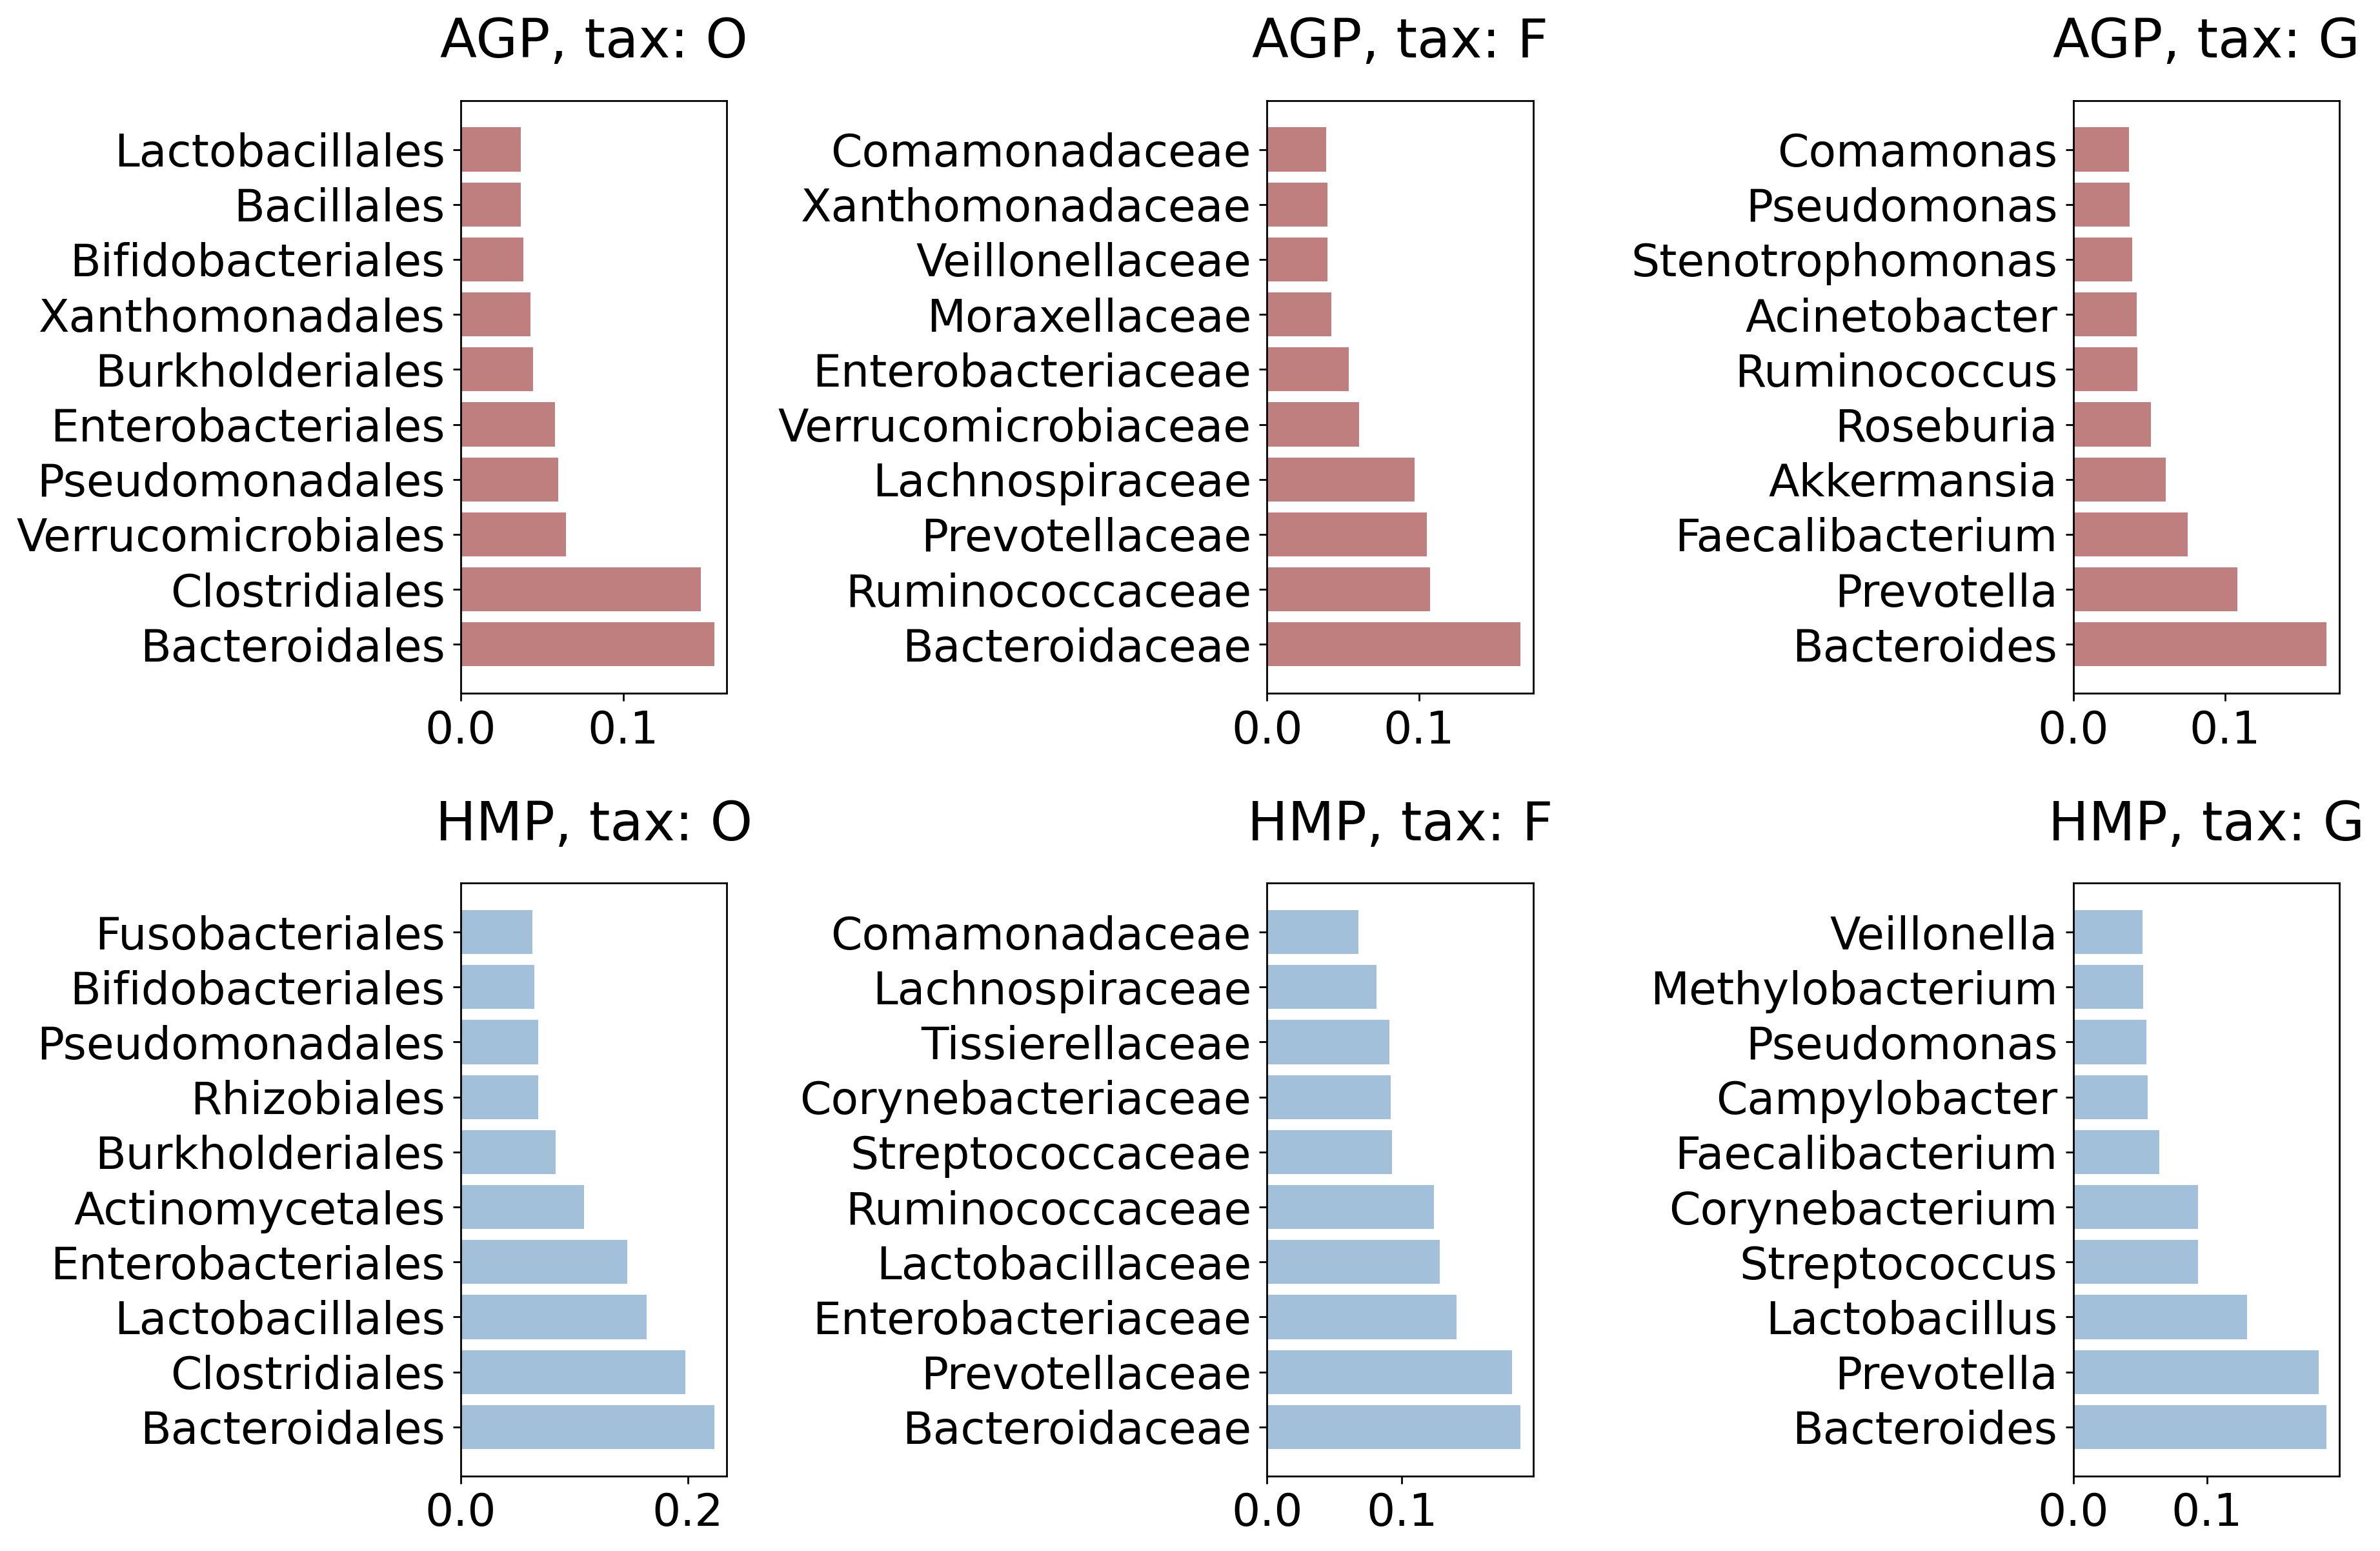

In [112]:
nshow = 10

sorted_cols = {}

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10), sharey=False, dpi=250)

for i,dataset_name in enumerate(['AGP', 'HMP']):
    for j,tax in enumerate(['o', 'f', 'g']): 

        label = '_'.join([dataset_name, tax])
        score_label = scores[label]

        scores_argsort = score_label.argsort()[::-1]

        scores_sorted = score_label[scores_argsort]
        labels_sorted = np.array(cols[label])[scores_argsort]

        axes[i,j].barh(labels_sorted[:nshow],
                scores_sorted[:nshow],
                alpha=0.5, 
                color=color_dict[dataset_name]
               )

        axes[i,j].set_title(dataset_name + f', tax: {tax.capitalize()}')

plt.tight_layout()
plt.show()

# Small datasets PCA

In [99]:
# color_dict = {'Sanger':'teal', 'Illumina':'peru', 'Pyroseq':'purple'}

# plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})
# plt.figure(figsize=(7,5), dpi=300)
# plt.title(f"Cumulative explained variance", fontsize=20)
# plt.xlabel("Number of PCs", fontsize=20)

# plt.grid(linestyle="dotted")

# cols = {}
# scores = {}

# for label,pca in pca_models.items():
    
#     if not label.split('_')[0] in color_dict:
#         continue
    
#     ev = np.cumsum(pca.explained_variance_ratio_)
    
    
#     dataset_name, tax_name = label.split('_')
#     label_neat = dataset_name + f', tax: {tax_name.capitalize()}'
    
#     plt.plot(ev, 
#              linewidth=3, 
#              label=label_neat,
#              alpha=0.6,
#              color=color_dict[dataset_name],
#              linestyle='solid'
#             )  
    
#     loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
#     loadings_scores = np.linalg.norm(loadings, axis=1)
    
#     cols[label] = list(preprocessed_data[label].columns)
#     scores[label] = loadings_scores
    
#     for aux_col in ['', '1', '-1']:
#         try:
#             aux_ind = cols[label].index(aux_col)
#             cols[label].pop(aux_ind)
#             scores[label] = np.delete(scores[label], aux_ind)
#         except Exception as e:
#             print(e)
#             continue
            
# plt.hlines(0.99,0,100,linestyle='--', label='0.99 threshold')

# plt.xscale('log')
# plt.ylim(0.65, 1.)
# plt.legend(fontsize=15, loc='lower right')    
# plt.show()

In [100]:
# nshow = 10

# sorted_cols = {}

# fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5), dpi=300)
# for i,(label, score_label) in enumerate(scores.items()):

#     scores_argsort = score_label.argsort()[::-1]
    
#     scores_sorted = score_label[scores_argsort]
#     labels_sorted = np.array(cols[label])[scores_argsort]

#     dataset_name, tax_name = label.split('_')
#     axes[i].barh(labels_sorted[:nshow],
#             scores_sorted[:nshow],
#             alpha=0.5, 
#             color=color_dict[dataset_name]
#            )

#     axes[i].set_title(dataset_name + f', tax: G')

# plt.tight_layout()
    
# plt.show()

# Calculate pairwise distances*
*for the faster computation

In [38]:
from scipy.spatial.distance import braycurtis, pdist, squareform, jensenshannon
from joblib import Parallel, delayed

In [39]:
# distance_root = f'distances_processed' + DATA_SPECIFICATION
# os.makedirs(distance_root, exist_ok=True)
# distances_names = ['L1', 'L2', 'JS', 'BC']

In [41]:
def compute_pdist_l1(data, name, distance_root):
    data_ = data.copy()
    S = squareform(pdist(data_, metric='minkowski', p=1))
    path = os.path.join(distance_root, f'orig_L1_{name}')
    np.save(path, S)
    
_ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l1)(data.drop(['-1', '1'], 
                                                                                axis=1, 
                                                                                errors='ignore').values, 
                                                                      name, 
                                                                      distance_root) 
                                        for name, data in preprocessed_data.items())


In [42]:
def compute_pdist_l2(data, name, distance_root):
    data_ = data.copy()
    S = squareform(pdist(data_, metric='minkowski', p=2))
    path = os.path.join(distance_root, f'orig_L2_{name}')
    np.save(path, S)
    
_ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l2)(data.drop(['-1', '1'], 
                                                                                axis=1, 
                                                                                errors='ignore').values, 
                                                                      name, 
                                                                      distance_root) 
                                        for name, data in preprocessed_data.items())



In [37]:
def compute_pdist_js(data, name, distance_root):
    
    data_ = data.copy()
    data_ /= data_.sum(1, keepdims=True)
    
    N = data_.shape[0]
    S = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            d = jensenshannon(data_[i], data_[j])
            S[i,j] = d
            S[j,i] = d
            
    path = os.path.join(distance_root, f'orig_JS_{name}')
    np.save(path, S)
    
if 'JS' in distances_names:
    _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_js)(data.drop(['-1', '1'], 
                                                                                axis=1, 
                                                                                errors='ignore').values,
                                                                          name, 
                                                                          distance_root) 
                                            for name, data in preprocessed_data.items())

In [38]:
def compute_pdist_bc(data, name, distance_root):
    data_ = data.copy()
    N = data_.shape[0]
    data_ /= data_.sum(1, keepdims=True)
    
    S = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            d = braycurtis(data_[i], data_[j])
            S[i,j] = d
            S[j,i] = d
            
    path = os.path.join(distance_root, f'orig_BC_{name}')
    np.save(path, S)
    
if 'BC' in distances_names:
    _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_bc)(data.drop(['-1', '1'], 
                                                                                axis=1, 
                                                                                errors='ignore').values,
                                                                          name,
                                                                          distance_root) 
                                            for name, data in preprocessed_data.items())

In [ ]:
# # uncomment to use synthetic data
# distance_root = 'distances_processed_synth'
# os.makedirs(distance_root, exist_ok=True)
# # only L1 and L2 distances are supported
# distances_names = ['L1', 'L2']


# _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l1)(data.values, 
#                                                                       name, 
#                                                                       distance_root) 
#                                         for name, data in preprocessed_data.items())

# _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l2)(data.values, 
#                                                                       name, 
#                                                                       distance_root) 
#                                         for name, data in preprocessed_data.items())